# Fine-Tune a SciBERT Model
### Load queried data

In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

c:\Users\albbl\Documents\Studium\11_Semester\medtextclassification_repo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 1e-5
RANDOM_SEED = 42
MODEL_NAME = "allenai/scibert_scivocab_uncased"
LABELS_MAP = {
    "human_medicine":[1, 0],
    "veterinary_medicine":[0, 1]
    }
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [10]:
import itertools
from xml.etree.ElementTree import ElementTree
import pandas as pd


# Extract data from XML and create a DataFrame
xml_files = []
data_path = "../data-querying/results/"
results_folders = ["human_medical_data/", "veterinary_medical_data/"]
for folder in results_folders:
    xml_files.append(os.listdir(data_path + folder))

data_sets = [[], []]
record_sets = []

tree = ElementTree()

for i, med_field in enumerate(xml_files):
    med_field_lists = []
    for xml in med_field:
        temp = tree.parse(data_path + results_folders[i] + xml)
        med_field_lists.append(temp.findall('.//Rec'))
    record_sets.append(list(itertools.chain(*med_field_lists)))

progress_bar = tqdm(range(sum(len(x) for x in record_sets)))

for i, med_field in enumerate(LABELS_MAP):
    print(f"Processing medical field: {med_field}")
    labels = LABELS_MAP[med_field]
    for rec in record_sets[i]:
        try: 
            common = rec.find('.//Common')
            pmid = common.find('PMID').text
            text_types = [elem.text for elem in common.findall('Type')]
            title = common.find('Title').text
            abstract = common.find('Abstract').text
            mesh_term_list = rec.find('.//MeshTermList')
            mesh_terms = [term.text for term in mesh_term_list.findall('MeshTerm')]
        except Exception as e:
            print(f"An error occurred: {e}")
            print(f"Error occured for PMID: {pmid}")

        data_sets[i].append({'pmid': pmid, "text_types": text_types, 'title': title,
                    'abstract': abstract, 'meshtermlist': mesh_terms, 'labels': labels})
        progress_bar.update(1)

hum_df = pd.DataFrame(data_sets[0])
vet_df = pd.DataFrame(data_sets[1])

  5%|▌         | 4973/98998 [00:00<00:03, 24830.32it/s]

Processing medical field: human_medicine


 38%|███▊      | 38065/98998 [00:01<00:02, 25618.59it/s]

Processing medical field: veterinary_medicine


 97%|█████████▋| 95963/98998 [00:03<00:00, 32586.92it/s]

100%|██████████| 98998/98998 [00:20<00:00, 32586.92it/s]

In [ ]:
hum_df.describe()

In [ ]:
vet_df.describe()

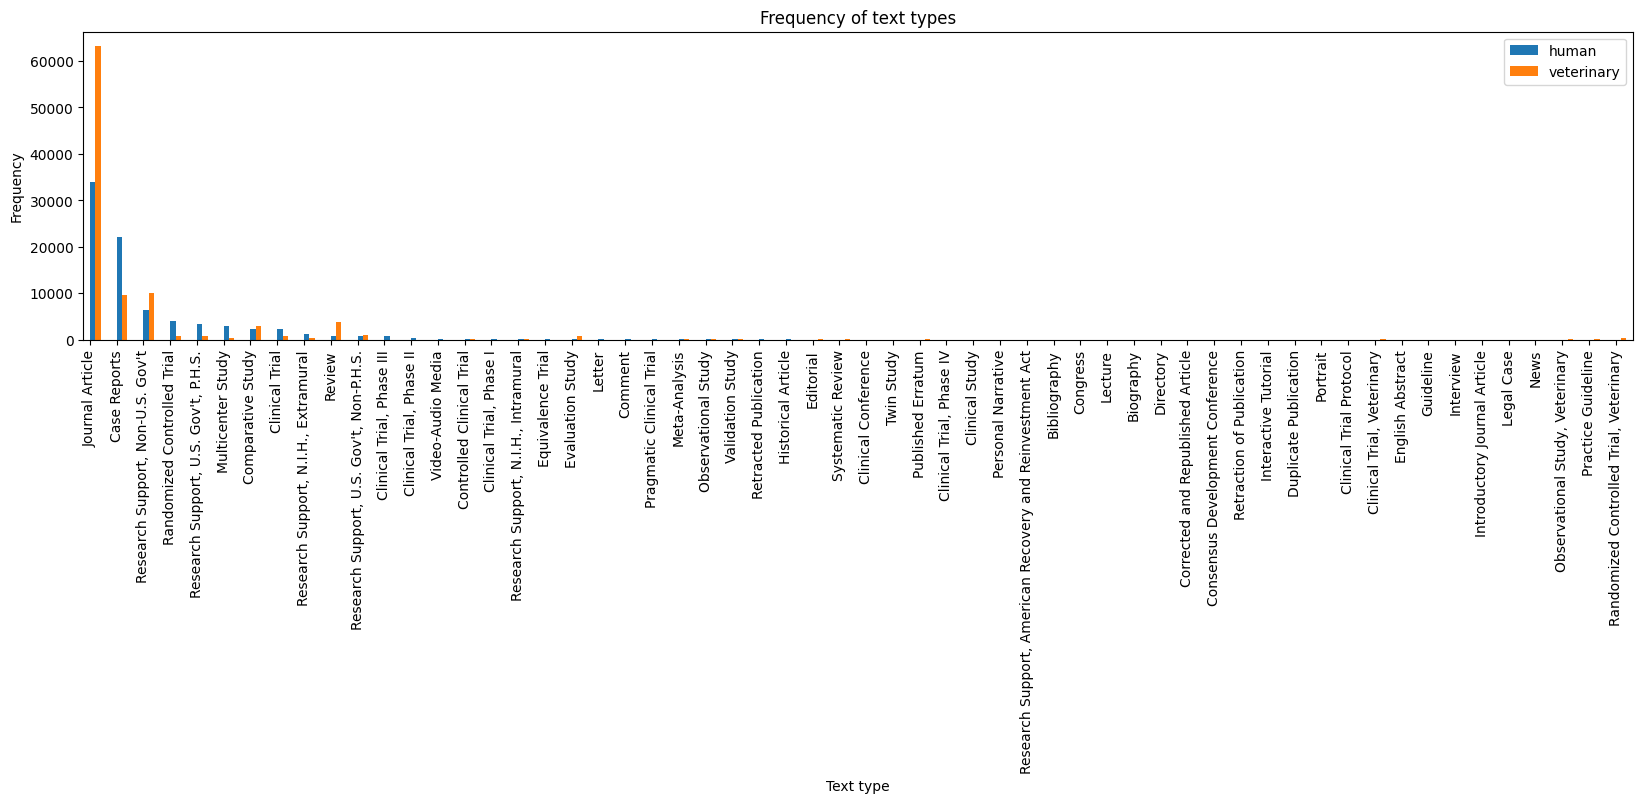

In [11]:
hum_exploded_df = hum_df.explode("text_types")
vet_exploded_df = vet_df.explode("text_types")

hum_text_type_counts = hum_exploded_df['text_types'].value_counts()
vet_text_type_counts = vet_exploded_df['text_types'].value_counts()

hum_test_type_counts_aligned, vet_test_type_counts_aligned = hum_text_type_counts.align(vet_text_type_counts, join='outer')
test_type_counts_aligned = pd.concat([hum_test_type_counts_aligned.sort_values(ascending=False), 
                                      vet_test_type_counts_aligned.sort_values(ascending=False)], 
                                     keys=['human', 'veterinary'], 
                                     axis=1)

test_type_counts_aligned.plot(kind='bar', position=0, width=0.4, figsize=(20, 4))

plt.title('Frequency of text types')
plt.xlabel('Text type')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encodings = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        ids = encodings['input_ids'].flatten()
        mask = encodings['attention_mask'].flatten()
        token_type_ids = encodings["token_type_ids"].flatten()


        return {
            'text': text,
            'input_ids': ids.to(device),
            'attention_mask': mask.to(device),
            'token_type_ids': token_type_ids.to(device),
            'labels': torch.tensor(labels, dtype=torch.long).to(device)
        }

In [ ]:
max_num = vet_text_type_counts["Case Reports"]

vet_case_rep = vet_df[vet_df['text_types'].apply(lambda x: "Case Reports" in x)].sample(max_num, random_state=42).reset_index(drop=True, inplace=False)
vet_jour_art = vet_df[vet_df['text_types'].apply(lambda x: "Journal Article" in x)].sample(max_num, random_state=42).reset_index(drop=True, inplace=False)

hum_case_rep = hum_df[hum_df['text_types'].apply(lambda x: "Case Reports" in x)].sample(max_num, random_state=42).reset_index(drop=True, inplace=False)
hum_jour_art = hum_df[hum_df['text_types'].apply(lambda x: "Journal Article" in x)].sample(max_num, random_state=42).reset_index(drop=True, inplace=False)

In [ ]:
pd.concat([hum_case_rep, hum_jour_art], axis=0)

In [ ]:
from sklearn.model_selection import train_test_split


hum_train_set, hum_test_set = train_test_split(
  pd.concat([hum_case_rep, hum_jour_art], axis=0),
  test_size=0.1,
  random_state=RANDOM_SEED
)

hum_train_set, hum_val_set = train_test_split(
  hum_train_set,
  test_size=0.2,
  random_state=RANDOM_SEED
)

vet_train_set, vet_test_set = train_test_split(
  pd.concat([vet_case_rep, vet_jour_art], axis=0),
  test_size=0.1,
  random_state=RANDOM_SEED
)

vet_train_set, vet_val_set = train_test_split(
  vet_train_set,
  test_size=0.2,
  random_state=RANDOM_SEED
)

train_set = pd.concat([hum_train_set, vet_train_set]).sample(frac=1).reset_index(drop=True, inplace=False)
val_set = pd.concat([hum_val_set, vet_val_set]).sample(frac=1).reset_index(drop=True, inplace=False)
test_set = pd.concat([hum_test_set, vet_test_set]).sample(frac=1).reset_index(drop=True, inplace=False)

print("TRAIN Dataset: {}".format(train_set.shape))
print("VAL Dataset: {}".format(val_set.shape))
print("TEST Dataset: {}".format(test_set.shape))

In [ ]:
test_set.labels.describe()

In [ ]:
ds = Dataset(train_set.abstract, train_set.labels, tokenizer, MAX_LEN)
ds.__getitem__(0)

In [ ]:
def get_dataloader(texts, targets, tokenizer, batch_size, max_len, num_workers=0):
    dataset = Dataset(texts.to_numpy(), targets, tokenizer, max_len)
    params = {
        "batch_size":batch_size,
        "num_workers":num_workers
    }
    dataloader = DataLoader(dataset, **params)
    
    return dataloader

In [ ]:
train_set["title_abstract"] = train_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
val_set["title_abstract"] = val_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_set["title_abstract"] = test_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
train_dataloader = get_dataloader(train_set.title_abstract, train_set.labels, tokenizer, TRAIN_BATCH_SIZE, MAX_LEN)
val_dataloader = get_dataloader(val_set.title_abstract, val_set.labels, tokenizer, VAL_BATCH_SIZE, MAX_LEN)
test_dataloader = get_dataloader(test_set.title_abstract, test_set.labels, tokenizer, TEST_BATCH_SIZE, MAX_LEN)

In [ ]:
data = next(iter(val_dataloader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

In [ ]:
data["input_ids"]

In [ ]:
data["attention_mask"]

In [ ]:
data["token_type_ids"]

In [ ]:
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(device)
model(data["input_ids"], data["attention_mask"], data["token_type_ids"])

In [16]:
from transformers import BertConfig


class SciBertClassifier(torch.nn.Module):

    def __init__(self, dropout=0.5):

        super(SciBertClassifier, self).__init__()
        self.scibert = AutoModel.from_pretrained(MODEL_NAME, num_labels=2)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(self.scibert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):

        scibert_output = self.scibert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
        dropout_output = self.dropout(scibert_output.pooler_output)
        output = self.linear(dropout_output)

        return output


In [ ]:
model = SciBertClassifier()
model = model.to(device)

In [ ]:
bert_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=2)
bert_tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

encodings = tokenizer(["This is a sentence", "This is another sentence"], return_tensors="pt")
encodings

In [ ]:
torch.nn.functional.softmax(model(data["input_ids"], data["attention_mask"], data["token_type_ids"]), dim=1)

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
output = model(data["input_ids"], data["attention_mask"], data["token_type_ids"])
#loss_fn(output, data["labels"])
print(output)
#print(data["labels"])

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
def eval_model(model, dataloader, loss_fn, device):
    model = model.eval()
    
    loss = 0.0
    correct_predictions = 0.0
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data["input_ids"].to(device, dtype = torch.long)
            attention_mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype = torch.long)
            labels = data["labels"].to(device, dtype = torch.float)
            
            outputs = model(input_ids, attention_mask, token_type_ids)
            loss += loss_fn(outputs, labels).item()
            
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()
            
            
    num_data = len(dataloader) * VAL_BATCH_SIZE
    return correct_predictions / num_data, loss / num_data

In [ ]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, scheduler, epochs):
    progress_bar = tqdm(range(len(train_dataloader) * epochs))
    model = model.train()
    history = []
    best_acc = 0
    
    for epoch_num in range(epochs):
        print("_" * 30)
        print(f'Epoch {epoch_num} started.')
        
        total_loss = 0
        correct_predictions = 0.0
        
        for data in train_dataloader:
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.float)

            outputs = model(input_ids, attention_mask, token_type_ids)
            preds = torch.argmax(outputs, dim=1)
            #print(correct_predictions)
            #print(outputs)
            #print(preds)
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()
            #print(labels)
            #print(torch.argmax(labels, dim=1))
            #print(correct_predictions)
            
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            
            loss.backward()
            # to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
                        
            progress_bar.update(1)
        
        num_data = len(train_dataloader) * TRAIN_BATCH_SIZE
        train_acc = correct_predictions / num_data
        train_loss = total_loss / num_data
        print(f'Epoch: {epoch_num}, Train Accuracy {train_acc}, Loss:  {train_loss}')

        val_acc, val_loss = eval_model(model, val_dataloader, loss_fn, device)
        print(f'Epoch: {epoch_num}, Validation Accuracy {val_acc}, Loss:  {val_loss}')
        
        history.append({"train_acc": train_acc, "train_loss": train_loss, "val_acc": val_acc, "val_loss": val_loss})
        
        if val_acc > best_acc:
            torch.save(model.state_dict(), 'best_model.bin')
            best_acc = val_acc
            
    return history

In [17]:
train = False

work_dir = "./"
model_filename = "best_model.bin"
filenames = os.listdir(work_dir)

if model_filename in filenames and not train:
    model = SciBertClassifier()
    model.load_state_dict(torch.load(work_dir + model_filename, map_location=torch.device('cpu')))
    model.to(device)
    print(f"{model_filename} loaded.")
else:
    print("No saved model found or forced to train.")

    torch.cuda.empty_cache()
    history = train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, scheduler, EPOCHS)

best_model.bin loaded.


In [ ]:
history = pd.DataFrame(history)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.9, 1])

In [8]:
def predict(model, texts, tokenizer, max_len=512):
    progress_bar = tqdm(range(len(texts)))
    
    predictions = []
    
    for data in texts:
        text = str(data)

        inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
        token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(ids, mask, token_type_ids)
        
        probabilities = torch.sigmoid(output.squeeze())
        predictions.append(probabilities)
        
        progress_bar.update(1)

    return predictions

In [ ]:
acc, loss = eval_model(model, test_dataloader, loss_fn, device)
print(f"TEST dataset - Accuracy: {acc}, Loss: {loss}")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

test_preds = predict(model, test_set.abstract, tokenizer)
test_labels = [labels.index(max(labels)) for labels in test_set.labels]
preds_labels = [torch.argmax(pred).item() for pred in test_preds]

classes = ["human", "veterinary"]

report = classification_report(test_labels, preds_labels, target_names=classes)
print(report)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

test_classes = ["human" if label == 0 else "veterinary" for label in test_labels]
preds_classes = ["human" if label == 0 else "veterinary" for label in preds_labels]
disp = ConfusionMatrixDisplay.from_predictions(test_classes, preds_classes, labels=classes, normalize="true", cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix (normalized)")
plt.show()

In [ ]:
text = ["Effects of vitamin B12 and folate deficiency on brain development in children. Folate deficiency in the periconceptional period contributes to neural tube defects; deficits in vitamin B12 (cobalamin) have negative consequences on the developing brain during infancy; and deficits of both vitamins are associated with a greater risk of depression during adulthood."]

predict(model, text, tokenizer)

**Analysis of PMC Patients Dataset**

In [ ]:
dir = "pmc_datasets/"
file_pmc_summaries = "PMC-Patients.json"
file_pmc_ppr = "PPR/PPR_corpus.jsonl"
file_pmc_par = "PAR/PAR_corpus.jsonl"

patients_summaries = pd.read_json(data_path + dir + file_pmc_summaries)
print("PMC Patients summaries loaded.")
par = pd.read_json(data_path + dir + file_pmc_par, lines = True)
print("PMC Patients PAR loaded.")
ppr = pd.read_json(data_path + dir + file_pmc_ppr, lines = True)
print("PMC Patients PPR loaded.")

In [ ]:
patients_summaries.head()

In [ ]:
par.head()

In [ ]:
ppr.head()

In [ ]:
summary_texts = patients_summaries.patient.sample(n=10000, random_state=42)
summary_texts.reset_index(drop=True, inplace=True)
summary_predictions = predict(model, summary_texts, tokenizer)

In [ ]:
par_texts = par.text.sample(n=10000, random_state=42)
par_texts.reset_index(drop=True, inplace=True)
par_predictions = predict(model, par_texts, tokenizer)

In [ ]:
ppr_texts = ppr.text.sample(n=10000, random_state=42)
ppr_texts.reset_index(drop=True, inplace=True)
ppr_predictions = predict(model, ppr_texts, tokenizer)

In [ ]:
def save_vet_predictions_as_json(predictions, texts, filename):
    label_preds = [torch.argmax(tensor) for tensor in predictions]
    label_preds = torch.stack(label_preds)
    vet_preds = (label_preds == 1).nonzero(as_tuple=True)[0].numpy(force=True)
    vet_preds
    vet_texts = texts.iloc[texts.index.isin(vet_preds)]
    probs = pd.Series(torch.stack([torch.max(tensor) for tensor in predictions]).numpy(force=True), name="probability")
    probs = probs.iloc[probs.index.isin(vet_preds)]
    vet_df = pd.concat([vet_texts, probs], axis=1)

    with open(filename, 'w') as f:
        f.write(vet_df.to_json(orient="records")[1:-1].replace('},{', '} {'))
        
    print(f"Predictions have been saved to {filename}.")
    
    return vet_df

In [ ]:
vet_summaries = save_vet_predictions_as_json(summary_predictions, summary_texts, "pmc_patients_predictions/summaries_vet.json")
vet_summaries

In [ ]:
vet_par = save_vet_predictions_as_json(par_predictions, par_texts, "pmc_patients_predictions/par_vet.json")
vet_par

In [ ]:
vet_ppr = save_vet_predictions_as_json(ppr_predictions, par_texts, "pmc_patients_predictions/ppr_vet.json")
vet_ppr

Interpretability

In [32]:
from captum.attr import TokenReferenceBase, LayerIntegratedGradients
from captum.attr import visualization as viz

def interpret_text(model_for_pred, model_for_embeddings, text, tokenizer, true_class):

    tokenized_input = tokenizer.encode_plus(
                                    text,
                                    None,
                                    add_special_tokens=True,
                                    max_length=MAX_LEN,
                                    #padding='max_length',
                                    truncation=True,
                                    return_token_type_ids=False,
                                    return_attention_mask=True,
                                    return_tensors="pt"
                                    )
    
    input_ids = tokenized_input["input_ids"]
    attention_mask = tokenized_input["attention_mask"]
    token_list = tokenizer.convert_ids_to_tokens(input_ids[0])

    baseline_ids = TokenReferenceBase(reference_token_idx=tokenizer.pad_token_id).generate_reference(
                                                                                        sequence_length=len(input_ids[0]), 
                                                                                        device="cpu"
                                                                                        ).unsqueeze(0)
    baseline_ids[0] = tokenizer.cls_token_id 
    baseline_ids[-1] = tokenizer.sep_token_id

    lig = LayerIntegratedGradients(
                lambda *inputs, **kwargs: model_for_pred(*inputs, **kwargs)[0],
                model_for_embeddings.embeddings
                )

    model_for_pred.zero_grad()
    attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=baseline_ids,
                                    additional_forward_args=(attention_mask, ),
                                    return_convergence_delta=True,
                                    internal_batch_size=1
                                    )
    
    attributions_sum = attributions.sum(dim=-1).squeeze(0) 
    attributions_sum = attributions_sum / torch.norm(attributions_sum)

    pred = predict(model_for_pred, [text], tokenizer)[0]
    print(pred)
    score_vis = viz.VisualizationDataRecord(
                        word_attributions = attributions_sum,
                        pred_prob = torch.max(pred),
                        pred_class = torch.argmax(pred).numpy(),
                        true_class = true_class,
                        attr_class = text,
                        attr_score = attributions_sum.sum(),       
                        raw_input_ids = token_list,
                        convergence_score = delta)

    viz.visualize_text([score_vis])

In [30]:
text = "A 5-year-old male castrated (MC) DSH cat was presented for evaluation of chronic cough and 1 week of tachypnea. Its environment was exclusively indoors with clumping clay cat litter noted as a potential inhalant exposure. Physical examination identified increased bronchovesicular sounds with a respiratory rate of 70 breaths per minute. Thoracic radiographs disclosed a moderate diffuse bronchointerstitial pattern, patchy areas of unstructured to structured (with ill-defined contours) interstitial pattern, and repeatable hypoinflation on all views (Figure A, B). On echocardiography, no evidence of pulmonary hypertension was found. On thoracic CT, multifocal subpleural linear opacities, parenchymal bands, and bronchiolectasis with no air trapping on expiratory breath-hold images were observed (Figure C, D). Bronchoalveolar lavage (BAL) cytology identified 45% nondegenerate neutrophils, and aerobic and anaerobic cultures were negative. Lung biopsy (Figure A-C) disclosed marked inflammation within and around terminal and respiratory bronchioles, with most severe inflammation in subpleural regions. Away from the severe fibrosis and inflammation, inflammation was centered upon respiratory bronchioles. Many of these bronchioles were lined by hyperplastic epithelium and surrounded by thickened smooth muscle. Rarely, small numbers of acicular particles suggestive of mineral origin were noted in macrophages and epithelial cells (not shown). Additional comments regarding mineral dust airway disease are presented in Box ."
true_class = 1
device = "cpu"
interpret_text(model, model.scibert, text, tokenizer, true_class)

100%|██████████| 1/1 [00:03<00:00,  3.36s/it]

tensor([6.4746e-05, 9.9989e-01])


In [29]:
text = "A 30-year-old man presented in October 2010 following a dog bite around his left superotemporal orbit. No ocular trauma was found on examination; however, an upper lid laceration had been previously repaired leaving a scar on the upper tarsus. The patient immediately complained of vertical diplopia following the attack; however, despite an extended period of observation lasting 9 months, he remained symptomatic. Visual acuity was 6\/6 OU, and he maintained single vision by using a chin-up head position. His ophthalmic examination was unremarkable. An orthoptist examination confirmed a marked restriction of upgaze. The patient was able to look up beyond the midline (see Hess Charts) (fig. ). There was no increase in intraocular pressure on attempted elevation. Prism cover testing was performed at distance fixation and showed a 40-prism diopter (PD) left hypotropia in upgaze, 35 PD in the primary position, and 3 PD hypophoria on the downgaze. He was binocular in downgaze, measuring 85\u2019 in depression using the Frisby test. On the MRI scan, the SR was grossly intact; however, motion blurring meant that it was not possible to exclude small abnormalities. Despite the absence of imaging confirmation, a diagnosis of isolated SR injury, secondary to the dog bite, was suspected. Forced duction testing under general anaesthetic was free in all positions, indicating that an elevating force was required. A left Knapp procedure was performed. The surgery was uneventful with scar tissue found around the SR. An ophthalmic examination 3 months following surgery showed a visual acuity of 6\/6 OU, and it also showed that the patient had a residual 20 PD hypotropia in the upgaze; he was, however, orthophoric in both primary positions and in the downgaze (fig. ). The patient was discharged with him being asymptomatic in the majority of his daily activities."
true_class = 0
device = "cpu"
interpret_text(model, model.scibert, text, tokenizer, true_class)

100%|██████████| 1/1 [00:06<00:00,  6.16s/it]

tensor([9.9991e-01, 1.6690e-04])


In [31]:
text = "Visceral leishmaniasis is a zoonotic vector-borne disease caused by Leishmania infantum. The infection often remains asymptomatic, though clinical forms may occur in immunosuppressed individuals. Although data on leishmaniasis in humans are available worldwide, the exposure to L. infantum of workers conducting outdoor activities has been scantly investigated, and it is limited to military personnel operating in endemic regions. This study aimed to assess the seroprevalence of L. infantum in different groups of outdoor workers and the occupational risk factors. The cross-sectional study was performed on 229 workers including forestry guards, farmers, veterinarians, geologists and agronomists from three regions of southern Italy (i.e., Apulia, Basilicata and Campania). All serum samples were screened for L. infantum-specific IgG/IgM by using automated indirect chemiluminescent immunoassays. Overall, 5.7% (13/229) of workers was positive to anti-L. infantum antibodies, with the highest seroprevalence in veterinarians (13.6%). An increased occupational health surveillance for L. infantum infection in outdoor workers is essential to better understand the risk of exposure in specific jobs. Furthermore, guidelines and education along with a One Health collaboration among veterinarians, physicians, parasitologists and occupational health care professionals are crucial for the prevention of this disease."
true_class = 0
device = "cpu"
interpret_text(model, model.scibert, text, tokenizer, true_class)

100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


tensor([1.1682e-04, 9.9990e-01])


In [37]:
text = "A man came to hospital because he had been bitten by a dog and needed medication."
true_class = 0
device = "cpu"
interpret_text(model, model.scibert, text, tokenizer, true_class)

100%|██████████| 1/1 [00:04<00:00,  4.69s/it]

tensor([9.9971e-01, 3.1622e-04])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (1.00),A man came to hospital because he had been bitten by a dog and needed medication.,-2.10,[CLS] a man came to hospital because he had been bit ##ten by a dog and needed medication . [SEP]


In [38]:
text = "A man came to hospital because he had been bitten by a dog and needed medication."
true_class = 1
device = "cpu"
interpret_text(model, model.scibert, text, tokenizer, true_class)

100%|██████████| 1/1 [00:05<00:00,  5.34s/it]

tensor([9.9992e-01, 9.4852e-05])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,0 (1.00),A man came to hospital because he had been bitten by a dog and needed medication.,0.04,[CLS] a man came to hospital because he had been bit ##ten by a dog and needed medication . [SEP]
